Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


 Training on cuda...
Epoch 1/23 | Loss: 0.6257/1.7904 | Acc: 0.8099/0.9580
 Saved Best Model
Epoch 2/23 | Loss: 0.1169/2.1825 | Acc: 0.9662/0.9774
Epoch 3/23 | Loss: 0.0583/1.5413 | Acc: 0.9829/0.9811
 Saved Best Model
Epoch 4/23 | Loss: 0.0388/1.1350 | Acc: 0.9869/0.9835
 Saved Best Model
Epoch 5/23 | Loss: 0.0284/3.0346 | Acc: 0.9894/0.9830
Epoch 6/23 | Loss: 0.0261/1.3695 | Acc: 0.9901/0.9863
Epoch 7/23 | Loss: 0.0204/0.0485 | Acc: 0.9926/0.9863
 Saved Best Model
Epoch 8/23 | Loss: 0.0207/0.9819 | Acc: 0.9910/0.9825
Epoch 9/23 | Loss: 0.0193/3.8227 | Acc: 0.9917/0.9873
Epoch 10/23 | Loss: 0.0191/4.7458 | Acc: 0.9925/0.9868
Epoch 11/23 | Loss: 0.0177/2.1931 | Acc: 0.9927/0.9863
 Early stopping triggered!


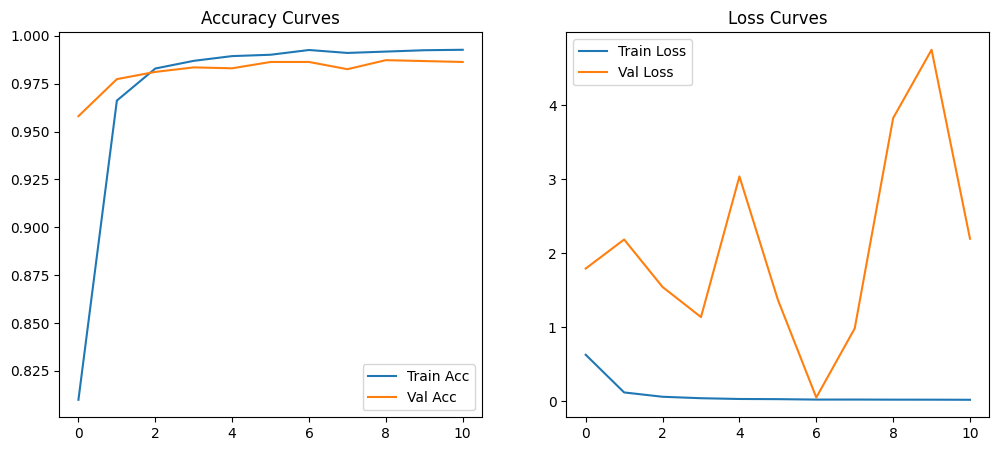

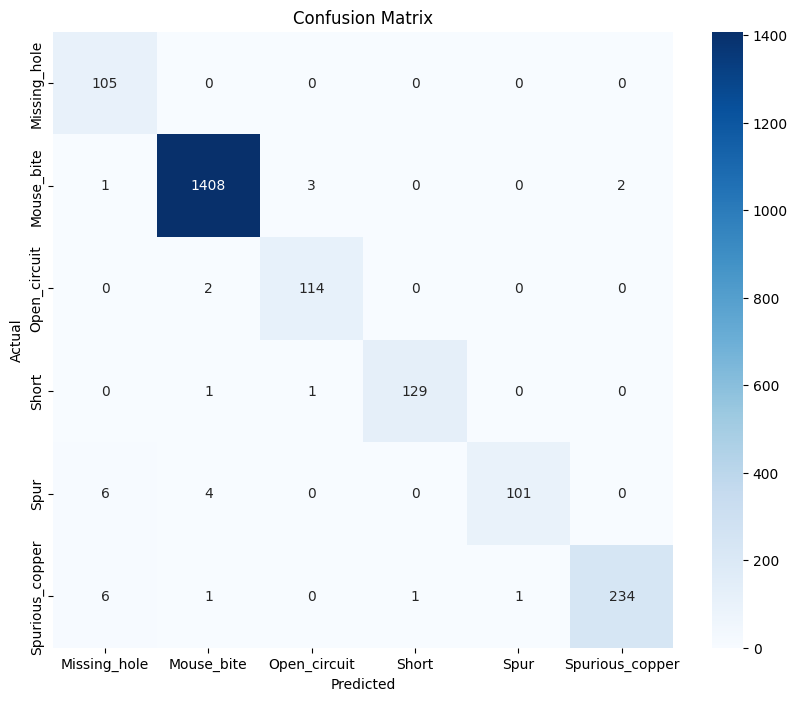


 Full Classification Report:
                  precision    recall  f1-score   support

   Missing_hole       0.89      1.00      0.94       105
     Mouse_bite       0.99      1.00      1.00      1414
   Open_circuit       0.97      0.98      0.97       116
          Short       0.99      0.98      0.99       131
           Spur       0.99      0.91      0.95       111
Spurious_copper       0.99      0.96      0.98       243

       accuracy                           0.99      2120
      macro avg       0.97      0.97      0.97      2120
   weighted avg       0.99      0.99      0.99      2120



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import numpy as np
import random
import os
import time

# --- 1. REPRODUCIBILITY & CONFIG ---
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

DATA_DIR = '/kaggle/input/updated-pcb/cropped_defects'
BATCH_SIZE = 32
EPOCHS = 23 
IMG_SIZE = 128
PATIENCE = 4 # Early stopping patience
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DATA AUGMENTATION (The Secret to 95%+) ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load Dataset
full_dataset = datasets.ImageFolder(DATA_DIR)
class_names = full_dataset.classes
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_data, val_data = random_split(full_dataset, [train_size, val_size])

train_data.dataset.transform = data_transforms['train']
val_data.dataset.transform = data_transforms['val']

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. MODEL DEFINITION (EfficientNet-B0) ---
model = models.efficientnet_b0(weights='IMAGENET1K_V1')
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# --- 4. TRAINING WITH EARLY STOPPING ---
history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
early_stop_counter = 0

print(f" Training on {DEVICE}...")

for epoch in range(EPOCHS):
    model.train()
    t_loss, t_corr = 0.0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        t_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        t_corr += torch.sum(preds == labels.data)

    train_loss = t_loss / train_size
    train_acc = t_corr.double() / train_size

    # Validation
    model.eval()
    v_loss_sum, v_corr = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            v_loss_sum += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            v_corr += torch.sum(preds == labels.data)

    val_loss = v_loss_sum / val_size
    val_acc = v_corr.double() / val_size
    
    scheduler.step(val_loss)
    
    history['train_acc'].append(train_acc.item())
    history['val_acc'].append(val_acc.item())
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss:.4f}/{val_loss:.4f} | Acc: {train_acc:.4f}/{val_acc:.4f}")

    # Early Stopping & Best Model Save
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_pcb_model.pth')
        early_stop_counter = 0
        print(" Saved Best Model")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(" Early stopping triggered!")
            break

# --- 5. VISUALIZATIONS & METRICS ---
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy Curves')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.savefig('learning_curves.png')
    plt.show()

plot_metrics(history)

# Final Detailed Evaluation
model.load_state_dict(torch.load('best_pcb_model.pth'))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')
plt.show()

# Classification Report (F1, Precision, Recall)
report = classification_report(y_true, y_pred, target_names=class_names)
print("\n Full Classification Report:\n", report)

with open('module3_final_report.txt', 'w') as f:
    f.write(report)
    f.write(f"\nBest Validation Loss: {best_val_loss:.4f}")

